In [16]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    x_train = (x_train.astype('float') - 127.5)/127.5
    x_train = x_train.reshape(60000,784)
    return (x_train,y_train,x_test,y_test)

In [5]:
(X_train,y_train,x_test,y_test) = load_data()
print(X_train.shape)

(60000, 784)


In [6]:
def adam_optimizer():
    return Adam(lr=0.0002,beta_1=0.5)

In [9]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(784,activation = 'tanh'))
    
    generator.compile(loss='binary_crossentropy',
                      optimizer= adam_optimizer())
    
    return generator

In [10]:
g = create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [11]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return discriminator

In [12]:
d = create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [13]:
def create_gan(discriminator,generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input,outputs=gan_output)
    gan.compile(loss='binary_crossentropy',optimizer='adam')
    return gan

In [14]:
g = create_generator()
d = create_discriminator()
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [18]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_updated %d.png' %epoch)

In [20]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] //batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for batch_idx in tqdm(range(batch_count)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            batch_start = batch_idx * batch_size
            image_batch =X_train[batch_start:(batch_start+batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 1


  1%|█                                                                                 | 6/468 [00:00<00:07, 57.84it/s]

Epoch 2


  1%|█▏                                                                                | 7/468 [00:00<00:07, 65.61it/s]

Epoch 3


  2%|█▍                                                                                | 8/468 [00:00<00:06, 70.99it/s]

Epoch 4


  1%|█▏                                                                                | 7/468 [00:00<00:06, 69.49it/s]

Epoch 5


  2%|█▍                                                                                | 8/468 [00:00<00:06, 71.62it/s]

Epoch 6


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.39it/s]

Epoch 7


  1%|█▏                                                                                | 7/468 [00:00<00:07, 62.67it/s]

Epoch 8


  1%|█▏                                                                                | 7/468 [00:00<00:07, 62.67it/s]

Epoch 9


  1%|█▏                                                                                | 7/468 [00:00<00:06, 69.48it/s]

Epoch 10


  1%|█▏                                                                                | 7/468 [00:00<00:07, 65.58it/s]

Epoch 11


  2%|█▍                                                                                | 8/468 [00:00<00:06, 71.60it/s]

Epoch 12


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.78it/s]

Epoch 13


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 14


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.54it/s]

Epoch 15


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.14it/s]

Epoch 16


  1%|▉                                                                                 | 5/468 [00:00<00:10, 44.76it/s]

Epoch 17


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.23it/s]

Epoch 18


  2%|█▍                                                                                | 8/468 [00:00<00:06, 69.75it/s]

Epoch 19


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.81it/s]

Epoch 20


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.98it/s]

Epoch 21


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.98it/s]

Epoch 22


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.11it/s]

Epoch 23


  2%|█▍                                                                                | 8/468 [00:00<00:06, 71.62it/s]

Epoch 24


  1%|█                                                                                 | 6/468 [00:00<00:08, 54.69it/s]

Epoch 25


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.81it/s]

Epoch 26


  1%|█▏                                                                                | 7/468 [00:00<00:07, 65.60it/s]

Epoch 27


  1%|█▏                                                                                | 7/468 [00:00<00:06, 69.50it/s]

Epoch 28


  2%|█▍                                                                                | 8/468 [00:00<00:06, 71.62it/s]

Epoch 29


  1%|█▏                                                                                | 7/468 [00:00<00:06, 66.22it/s]

Epoch 30


  1%|█▏                                                                                | 7/468 [00:00<00:06, 67.49it/s]

Epoch 31


  1%|█▏                                                                                | 7/468 [00:00<00:07, 60.51it/s]

Epoch 32


  1%|█▏                                                                                | 7/468 [00:00<00:06, 66.85it/s]

Epoch 33


  2%|█▍                                                                                | 8/468 [00:00<00:06, 69.75it/s]

Epoch 34


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.54it/s]

Epoch 35


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.03it/s]

Epoch 36


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.98it/s]

Epoch 37


  3%|██▍                                                                              | 14/468 [00:00<00:06, 67.03it/s]

Epoch 38


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.14it/s]

Epoch 39


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.39it/s]

Epoch 40


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.79it/s]

Epoch 41


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 42


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.56it/s]

Epoch 43


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 44


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.02it/s]

Epoch 45


  2%|█▍                                                                                | 8/468 [00:00<00:06, 70.36it/s]

Epoch 46


  2%|█▍                                                                                | 8/468 [00:00<00:06, 69.15it/s]

Epoch 47


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.56it/s]

Epoch 48


  3%|██▍                                                                              | 14/468 [00:00<00:06, 68.34it/s]

Epoch 49


  1%|█▏                                                                                | 7/468 [00:00<00:06, 67.49it/s]

Epoch 50


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.03it/s]

Epoch 51


  2%|█▍                                                                                | 8/468 [00:00<00:06, 70.97it/s]

Epoch 52


  2%|█▍                                                                                | 8/468 [00:00<00:06, 71.62it/s]

Epoch 53


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.98it/s]

Epoch 54


  2%|█▍                                                                                | 8/468 [00:00<00:06, 70.99it/s]

Epoch 55


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.06it/s]

Epoch 56


  1%|█▏                                                                                | 7/468 [00:00<00:06, 69.49it/s]

Epoch 57


  1%|█▏                                                                                | 7/468 [00:00<00:07, 60.51it/s]

Epoch 58


  1%|█▏                                                                                | 7/468 [00:00<00:06, 69.46it/s]

Epoch 59


  3%|██▍                                                                              | 14/468 [00:00<00:06, 68.28it/s]

Epoch 60


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.98it/s]

Epoch 61


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.39it/s]

Epoch 62


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.23it/s]

Epoch 63


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.39it/s]

Epoch 64


  3%|██▍                                                                              | 14/468 [00:00<00:06, 65.11it/s]

Epoch 65


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.99it/s]

Epoch 66


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 67


  1%|█▏                                                                                | 7/468 [00:00<00:06, 67.49it/s]

Epoch 68


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.14it/s]

Epoch 69


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 70


  1%|█                                                                                 | 6/468 [00:00<00:07, 58.41it/s]

Epoch 71


  2%|█▉                                                                               | 11/468 [00:00<00:10, 45.30it/s]

Epoch 72


  1%|█▏                                                                                | 7/468 [00:00<00:07, 59.97it/s]

Epoch 73


  1%|█▏                                                                                | 7/468 [00:00<00:07, 64.99it/s]

Epoch 74


  1%|█▏                                                                                | 7/468 [00:00<00:07, 65.59it/s]

Epoch 75


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.81it/s]

Epoch 76


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.81it/s]

Epoch 77


  1%|█▏                                                                                | 7/468 [00:00<00:07, 62.67it/s]

Epoch 78


  3%|██▍                                                                              | 14/468 [00:00<00:06, 68.14it/s]

Epoch 79


  1%|█▏                                                                                | 7/468 [00:00<00:07, 63.81it/s]

Epoch 80


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.56it/s]

Epoch 81


  1%|█                                                                                 | 6/468 [00:00<00:08, 52.77it/s]

Epoch 82


  1%|█▏                                                                                | 7/468 [00:00<00:06, 66.20it/s]

Epoch 83


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.55it/s]

Epoch 84


  1%|█▏                                                                                | 7/468 [00:00<00:06, 66.19it/s]

Epoch 85


  1%|█▏                                                                                | 7/468 [00:00<00:06, 67.36it/s]

Epoch 86


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.79it/s]

Epoch 87


  1%|█                                                                                 | 6/468 [00:00<00:07, 59.57it/s]

Epoch 88


  2%|█▍                                                                                | 8/468 [00:00<00:06, 74.97it/s]

Epoch 89


  1%|█▏                                                                                | 7/468 [00:00<00:07, 59.99it/s]

Epoch 90


  1%|█▏                                                                                | 7/468 [00:00<00:07, 62.65it/s]

Epoch 91


  2%|█▍                                                                                | 8/468 [00:00<00:06, 69.15it/s]

Epoch 92


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.55it/s]

Epoch 93


  1%|█▏                                                                                | 7/468 [00:00<00:07, 61.85it/s]

Epoch 94


  1%|█▏                                                                                | 7/468 [00:00<00:06, 66.22it/s]

Epoch 95


  1%|▉                                                                                 | 5/468 [00:00<00:09, 47.75it/s]

Epoch 96


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.78it/s]

Epoch 97


  2%|█▍                                                                                | 8/468 [00:00<00:06, 70.99it/s]

Epoch 98


  1%|█▏                                                                                | 7/468 [00:00<00:06, 68.81it/s]

Epoch 99


  2%|█▍                                                                                | 8/468 [00:00<00:06, 72.91it/s]

Epoch 100


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 64.47it/s]


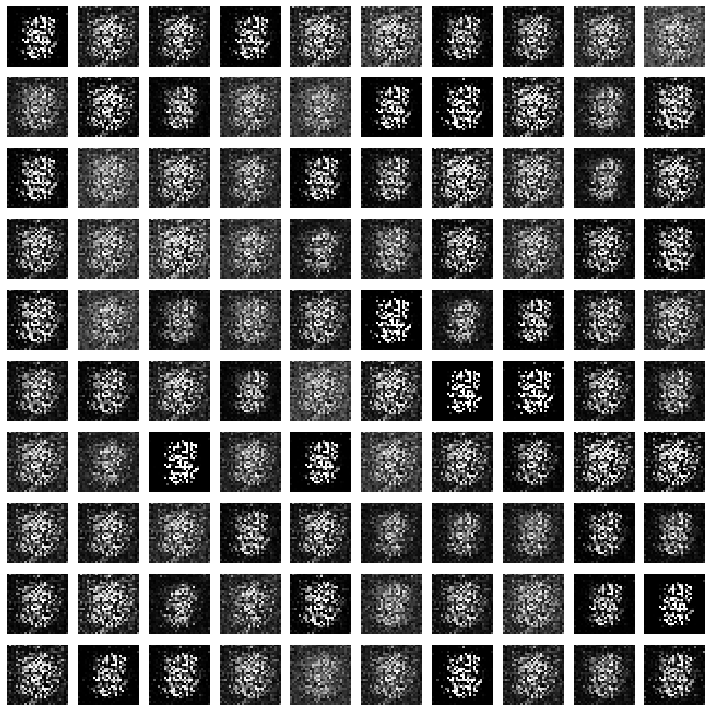

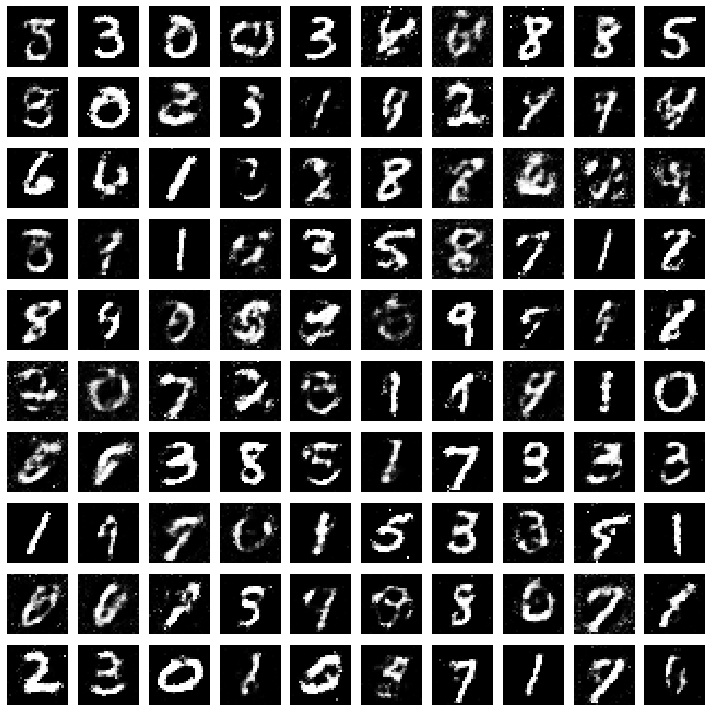

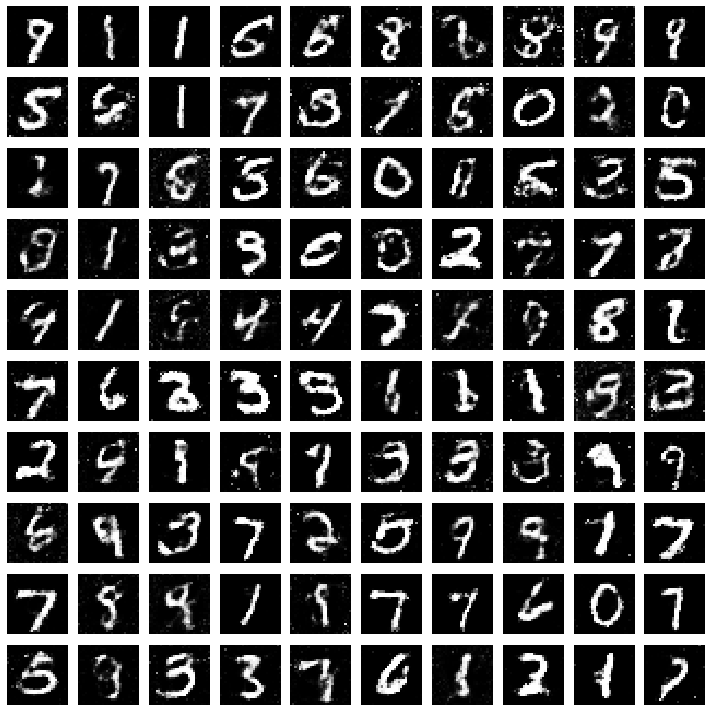

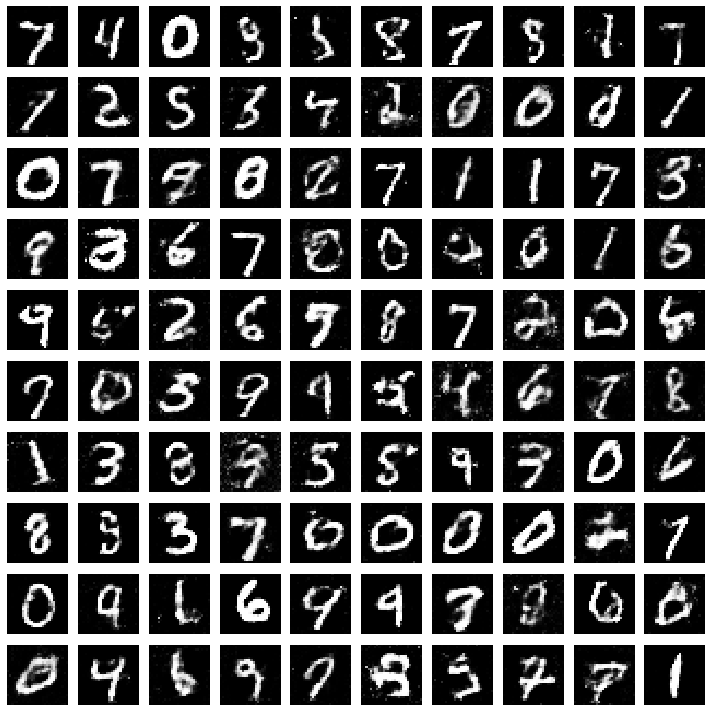

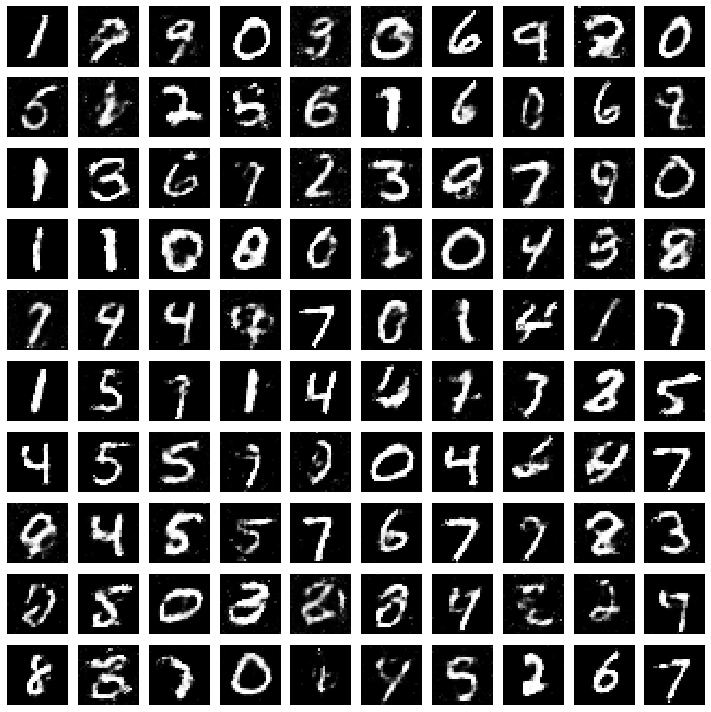

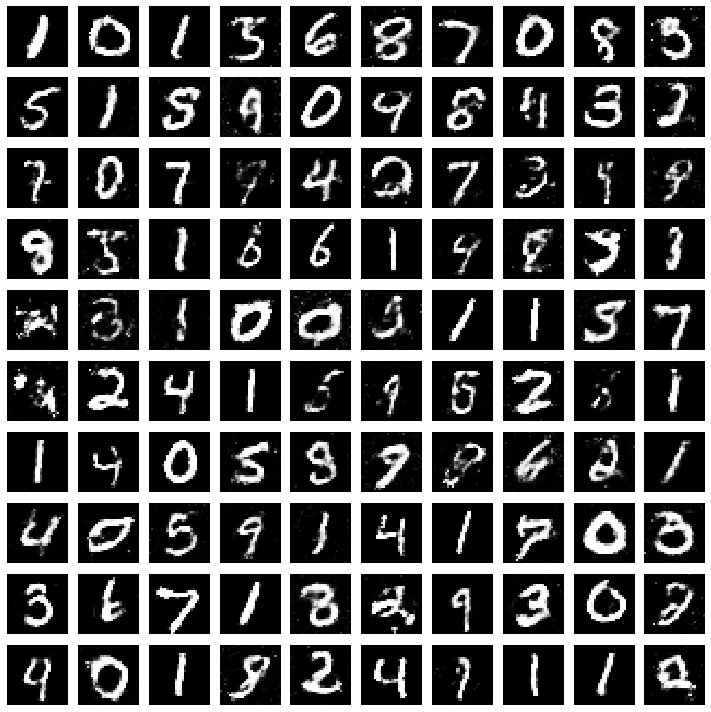

In [21]:
training(100,128)

In [73]:
noise= np.random.normal(0,1,[100,100])

In [74]:
g = create_generator()
d = create_discriminator()

In [75]:
gi = g.predict(noise)

In [76]:
gi.shape

(100, 784)

In [1]:
image_batch.shape

NameError: name 'image_batch' is not defined

In [5]:
(X_train,y_train,x_test,y_test) = load_data()
print(X_train.shape)

(60000, 784)


In [6]:
noise= np.random.normal(0,1,300*28*28)

In [7]:
noise= noise.reshape((300,28,28,1))

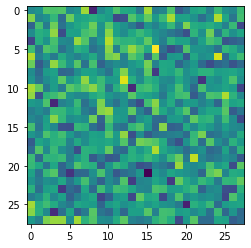

In [11]:
plt.imshow(noise[1,:,:,0])